In [63]:
import pandas as pd; import numpy as np; import matplotlib.pyplot as plt;

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey,acorr_ljungbox
from statsmodels.stats.sandwich_covariance import cov_hac

from scipy.stats import f

import warnings as yapping; yapping.simplefilter('ignore')
from itertools import combinations

import os
data_dir = './data'

In [64]:
origin = pd.read_excel(os.path.join(data_dir, 'advert.xlsx'),header=0)
origin

,x,y
0,4,27.0
1,3,25.7
2,0,24.3
3,5,23.2
4,3,27.6
...,...,...
115,1,25.3
116,8,22.5
117,8,25.7
118,0,29.3


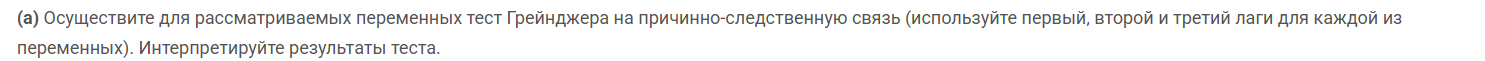

In [65]:
def adf_stationary_test(series, signif=0.05):
    result = adfuller(series, autolag='AIC')
    p_value = result[1]
    return (p_value < signif)


print(f'Ряд x {'' if adf_stationary_test(origin.x) else 'не'}стационарен')
print(f'Ряд y {'' if adf_stationary_test(origin.y) else 'не'}стационарен')

Ряд x стационарен
Ряд y стационарен


In [66]:
def granger_causality(X: pd.Series, Y: pd.Series, max_lag: int,verbose:bool = False) -> dict:
    """
    Выполняет тест Грейнджера на причинно-следственную связь.
    
    Аргументы:
        X (pd.Series): Первый временной ряд.
        Y (pd.Series): Второй временной ряд.
        max_lag (int): Максимальное количество лагов для проверки.
        verbose (bool,optional): Осуществить вывод результатов
    
    Возвращает:
        dict: Для каждого лага возвращает F-статистику и p-значение.
    """
    if len(X) != len(Y):
        raise ValueError("Длины временных рядов должны совпадать")
    
    results = {}
    
    for lag in range(1, max_lag + 1):
        # Создаем лаги для X и Y
        X_lags = pd.concat([X.shift(i) for i in range(1, lag+1)], axis=1)
        Y_lags = pd.concat([Y.shift(i) for i in range(1, lag+1)], axis=1)
        
        # Выравниваем индексы и удаляем пропуски
        common_idx = X_lags.dropna().index.intersection(Y_lags.dropna().index).intersection(Y.index)
        X_lags = X_lags.loc[common_idx].values
        Y_lags = Y_lags.loc[common_idx].values
        Y_current = Y.loc[common_idx].values
        
        # Матрицы регрессоров
        X_unrestricted = np.column_stack((np.ones(len(X_lags)), X_lags, Y_lags))
        X_restricted = np.column_stack((np.ones(len(Y_lags)), Y_lags))
        
        # Рассчитываем коэффициенты и RSS
        coeffs_unr, _, _, _ = np.linalg.lstsq(X_unrestricted, Y_current, rcond=None)
        rss_unr = ((Y_current - X_unrestricted @ coeffs_unr)**2).sum()
        
        coeffs_res, _, _, _ = np.linalg.lstsq(X_restricted, Y_current, rcond=None)
        rss_res = ((Y_current - X_restricted @ coeffs_res)**2).sum()
        
        # F-статистика
        n = len(Y_current)
        k_unr = X_unrestricted.shape[1]
        k_res = X_restricted.shape[1]
        q = k_unr - k_res
        
        f_stat = ((rss_res - rss_unr)/q) / (rss_unr/(n - k_unr))
        p_val = 1 - f.cdf(f_stat, q, n - k_unr)
        
        results[lag] = {'f_statistic': f_stat, 'p_value': p_val}
        
    if verbose:
        tab = 6+len(str(max_lag))
        for lag, res in results.items():
            print(f"{f"Лаг {lag}":^{tab}}: Причинность X → Y {'' if res['p_value']<0.05 else 'не'} подтверждается\n{' '*(tab+2)}F={res['f_statistic']:.3f}\n{' '*(tab+2)}p={res['p_value']:.3f}\n")
    return results

max_lag = 3
results = granger_causality(origin.x, origin.y,max_lag, True)

 Лаг 1 : Причинность X → Y  подтверждается
         F=518.530
         p=0.000

 Лаг 2 : Причинность X → Y  подтверждается
         F=253.251
         p=0.000

 Лаг 3 : Причинность X → Y  подтверждается
         F=166.970
         p=0.000



In [67]:
results = granger_causality(origin.y, origin.x,max_lag, True)

 Лаг 1 : Причинность X → Y не подтверждается
         F=0.636
         p=0.427

 Лаг 2 : Причинность X → Y не подтверждается
         F=0.004
         p=0.996

 Лаг 3 : Причинность X → Y не подтверждается
         F=0.353
         p=0.787



$X$ скорее всего является причиной $Y$

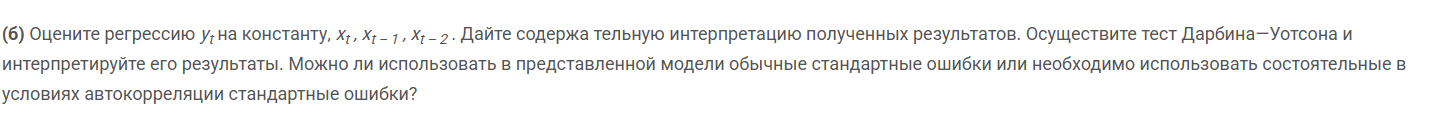

In [68]:
x = origin.x
y = origin.y


com = []
for i in range(1,5):
    com.extend(combinations(['const','xt','xt_1','xt_2'],i))
com

# Создание лагов
x_lag1 = x.shift(1)
x_lag2 = x.shift(2)

# Удаление пропущенных значений
data = pd.concat([y, x, x_lag1, x_lag2], axis=1).dropna()
data.columns =['y','x', 'x_lag1', 'x_lag2']

y_clean = data['y']
X_clean = data[['x', 'x_lag1', 'x_lag2']]

# Добавление константы
X = sm.add_constant(X_clean)

# Оценка модели
model = sm.OLS(y_clean, X).fit()
display(model.summary())

# Тест Дарбина-Уотсона
dw_stat = durbin_watson(model.resid)
print(f"\nТест Дарбина-Уотсона: {dw_stat:.3f}")

# Если DW ≈ 2 → автокорреляции нет. Иначе используем HAC-ошибки:
if not (1.8 < dw_stat < 2.2):
    print("Обнаружена автокорреляция. Используются HAC-ошибки.")
    hac_cov = cov_hac(model, nlags=2)
    hac_se = np.sqrt(np.diag(hac_cov))
    print("HAC-ошибки:", hac_se)
else:
    print("Автокорреляция отсутствует. Обычные ошибки корректны.")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     125.2
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           6.37e-36
Time:                        11:13:21   Log-Likelihood:                -211.22
No. Observations:                 118   AIC:                             430.4
Df Residuals:                     114   BIC:                             441.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6889      0.387     55.991      0.000      20.922      22.456
x             -0.0110      0.046     -0.237      0.813      -0.102       0.081
x_lag1         0.8305      0.047     17.842      0.000       0.738       0.923
x_lag2         0.4149      0.047      8.831      0.000       0.322       0.508
==============================================================================
Omnibus:                        3.849   Durbin-Watson:                   1.117
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                2.202
Skew:                          -0.028   Prob(JB):                        0.333
Kurtosis:                       2.333   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Тест Дарбина-Уотсона: 1.117
Обнаружена автокорреляция. Используются HAC-ошибки.
HAC-ошибки: [0.37406745 0.04444578 0.04468131 0.04445356]


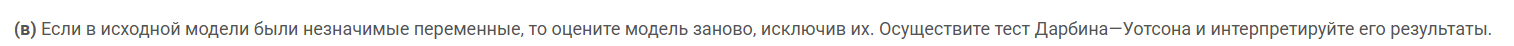

переменная $x_t$ оказалась незначимой

In [69]:
x = origin.x
y = origin.y


com = []
for i in range(1,5):
    com.extend(combinations(['const','xt','xt_1','xt_2'],i))
com

# Создание лагов
x_lag1 = x.shift(1)
x_lag2 = x.shift(2)

# Удаление пропущенных значений
data = pd.concat([y, x_lag1, x_lag2], axis=1).dropna()
data.columns =['y', 'x_lag1', 'x_lag2']

y_clean = data['y']
X_clean = data[[ 'x_lag1', 'x_lag2']]

# Добавление константы
X = sm.add_constant(X_clean)

# Оценка модели
model = sm.OLS(y_clean, X).fit()
display(model.summary())

# Тест Дарбина-Уотсона
dw_stat = durbin_watson(model.resid)
print(f"\nТест Дарбина-Уотсона: {dw_stat:.3f}")

# Если DW ≈ 2 → автокорреляции нет. Иначе используем HAC-ошибки:
if not (1.8 < dw_stat < 2.2):
    print("Обнаружена автокорреляция. Используются HAC-ошибки.")
    hac_cov = cov_hac(model, nlags=2)
    hac_se = np.sqrt(np.diag(hac_cov))
    print("HAC-ошибки:", hac_se)
else:
    print("Автокорреляция отсутствует. Обычные ошибки корректны.")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     189.3
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           4.20e-37
Time:                        11:13:21   Log-Likelihood:                -211.25
No. Observations:                 118   AIC:                             428.5
Df Residuals:                     115   BIC:                             436.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6406      0.328     65.939      0.000      20.991      22.291
x_lag1         0.8316      0.046     18.026      0.000       0.740       0.923
x_lag2         0.4138      0.047      8.886      0.000       0.322       0.506
==============================================================================
Omnibus:                        3.931   Durbin-Watson:                   1.113
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                2.225
Skew:                          -0.020   Prob(JB):                        0.329
Kurtosis:                       2.329   Cond. No.                         16.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Тест Дарбина-Уотсона: 1.113
Обнаружена автокорреляция. Используются HAC-ошибки.
HAC-ошибки: [0.28586917 0.04294313 0.04331707]


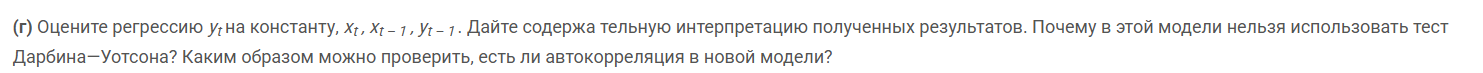

**1. Оценка регрессии и интерпретация результатов**  
Модель:  
$$ y_t = \beta_0 + \beta_1 x_t + \beta_2 x_{t-1} + \beta_3 y_{t-1} + \varepsilon_t $$  

- **β₀ (константа)**: Значение $ y_t $, когда все предикторы ($ x_t, x_{t-1}, y_{t-1} $) равны нулю.  
- **β₁**: Мгновенное влияние текущего значения $ x_t $ на $ y_t $.  
- **β₂**: Влияние $ x $ с лагом 1 период на текущее $ y_t $.  
- **β₃**: Влияние предыдущего значения $ y_{t-1} $ на текущее $ y_t $. Это указывает на инерционность процесса (например, зависимость текущего спроса от прошлого) .  

---

**2. Почему тест Дарбина-Уотсона неприменим?**  
Тест Дарбина-Уотсона некорректен в моделях с **лаговой зависимой переменной** ($ y_{t-1} $). Причина:  
- $ y_{t-1} $ коррелирует с ошибками $ \varepsilon_t $, так как $ y_{t-1} $ включает в себя прошлые значения $ \varepsilon_{t-1} $.  
- Это нарушает предпосылку теста о независимости регрессоров и ошибок, делая статистику DW смещенной .  

---

**3. Альтернативные методы проверки автокорреляции**  
Для выявления автокорреляции в такой модели используют:  
- **Тест Бройша-Годфри (BG)**:  
  Проверяет гипотезу о наличии автокорреляции до порядка $ p $. Для этого строится вспомогательная регрессия остатков $ \hat{\varepsilon}_t $ на все исходные регрессоры и их лаги (например, $ \hat{\varepsilon}_{t-1}, \hat{\varepsilon}_{t-2} $) .  
  - **Статистика теста**: $ n \cdot R^2 $ (асимптотически распределена как $ \chi^2_p $).  

- **Критерий Льюнга-Бокса**:  
  Анализирует автокорреляционную функцию (ACF) остатков для проверки значимости корреляции до лага $ m $.  
  - **Статистика**: $ Q = n(n+2) \sum_{k=1}^m \frac{\hat{\rho}_k^2}{n-k} $, где $ \hat{\rho}_k $ — выборочная автокорреляция .  

In [70]:
# Удаление пропусков
data = pd.concat([y, x, x.shift(1), y.shift(1)], axis=1).dropna()
y_clean = data.iloc[:, 0]
X_clean = data.iloc[:, 1:]

# Добавление константы
X = sm.add_constant(X_clean)

# Оценка модели
model = sm.OLS(y_clean, X).fit()
display(model.summary())

# Тест Бройша-Годфри на автокорреляцию 2-го порядка
bg_test = acorr_breusch_godfrey(model, nlags=2)
print(f"\nТест Бройша-Годфрей:\n\nLM-статистика = {bg_test[0]:.3f}, \np-значение = {bg_test[1]:.3f}, \n{'При' if bg_test[1]<0.05 else 'От' }сутствует автокорреляция 2 порядка\n")


print(f"\nТест Льюнга-Бокса для лагов 1-10:\n")
# Тест Льюнга-Бокса для лагов 1-10
lb_test = acorr_ljungbox(model.resid, lags=10, return_df=True)
for i in range(10):
    print(f'{'При' if lb_test.iloc[i,1]<0.05 else 'От' }сутствует автокорреляция {i+1} порядка')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     229.6
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           2.23e-48
Time:                        11:13:21   Log-Likelihood:                -183.63
No. Observations:                 119   AIC:                             375.3
Df Residuals:                     115   BIC:                             386.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9294      0.990     10.035      0.000       7.969      11.889
x             -0.0077      0.036     -0.215      0.830      -0.079       0.064
x              0.8173      0.036     22.534      0.000       0.745       0.889
y              0.5026      0.035     14.159      0.000       0.432       0.573
==============================================================================
Omnibus:                        2.155   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.545
Skew:                          -0.006   Prob(JB):                        0.462
Kurtosis:                       2.442   Cond. No.                         262.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Тест Бройша-Годфрей:

LM-статистика = 1.558, 
p-значение = 0.459, 
Отсутствует автокорреляция 2 порядка


Тест Льюнга-Бокса для лагов 1-10:

Отсутствует автокорреляция 1 порядка
Отсутствует автокорреляция 2 порядка
Присутствует автокорреляция 3 порядка
Отсутствует автокорреляция 4 порядка
Отсутствует автокорреляция 5 порядка
Отсутствует автокорреляция 6 порядка
Отсутствует автокорреляция 7 порядка
Отсутствует автокорреляция 8 порядка
Отсутствует автокорреляция 9 порядка
Отсутствует автокорреляция 10 порядка


In [71]:
# Удаление пропусков
data = pd.concat([y, x.shift(1), y.shift(1)], axis=1).dropna()
y_clean = data.iloc[:, 0]
X_clean = data.iloc[:, 1:]

# Добавление константы
X = sm.add_constant(X_clean)

# Оценка модели
model = sm.OLS(y_clean, X).fit()
display(model.summary())

# Тест Бройша-Годфри на автокорреляцию 2-го порядка
bg_test = acorr_breusch_godfrey(model, nlags=2)
print(f"\nТест Бройша-Годфрей:\n\nLM-статистика = {bg_test[0]:.3f}, \np-значение = {bg_test[1]:.3f}, \n{'При' if bg_test[1]<0.05 else 'От' }сутствует автокорреляция 2 порядка\n")


print(f"\nТест Льюнга-Бокса для лагов 1-10:\n")
# Тест Льюнга-Бокса для лагов 1-10
lb_test = acorr_ljungbox(model.resid, lags=10, return_df=True)
for i in range(10):
    print(f'p-значение = {lb_test.iloc[i,1]:.3f} | {'При' if lb_test.iloc[i,1]<0.05 else 'От' }сутствует автокорреляция {i+1} порядка')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     347.2
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.08e-49
Time:                        11:13:21   Log-Likelihood:                -183.65
No. Observations:                 119   AIC:                             373.3
Df Residuals:                     116   BIC:                             381.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9072      0.980     10.109      0.000       7.966      11.848
x              0.8181      0.036     22.771      0.000       0.747       0.889
y              0.5021      0.035     14.241      0.000       0.432       0.572
==============================================================================
Omnibus:                        2.028   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.363   Jarque-Bera (JB):                1.488
Skew:                          -0.006   Prob(JB):                        0.475
Kurtosis:                       2.452   Cond. No.                         258.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Тест Бройша-Годфрей:

LM-статистика = 1.525, 
p-значение = 0.466, 
Отсутствует автокорреляция 2 порядка


Тест Льюнга-Бокса для лагов 1-10:

p-значение = 0.976 | Отсутствует автокорреляция 1 порядка
p-значение = 0.469 | Отсутствует автокорреляция 2 порядка
p-значение = 0.029 | Присутствует автокорреляция 3 порядка
p-значение = 0.058 | Отсутствует автокорреляция 4 порядка
p-значение = 0.098 | Отсутствует автокорреляция 5 порядка
p-значение = 0.129 | Отсутствует автокорреляция 6 порядка
p-значение = 0.184 | Отсутствует автокорреляция 7 порядка
p-значение = 0.135 | Отсутствует автокорреляция 8 порядка
p-значение = 0.127 | Отсутствует автокорреляция 9 порядка
p-значение = 0.123 | Отсутствует автокорреляция 10 порядка


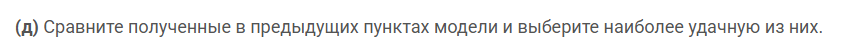

Лучшей оказалась модель:  
$$ y_t = \beta_0 + \beta_2 x_{t-1} + \beta_3 y_{t-1} + \varepsilon_t $$  


In [81]:
from IPython.display import Math
params = model.params.values
Math(f'y = {params[0]:.4f} + {params[1]:.4f}' + r'\cdot x_{t-1} + ' + f'{params[2]:.4f}' + r'\cdot y_{t-1} + \varepsilon_t')

<IPython.core.display.Math object>

Так как у нее нет незначимых переменных, отсутствует автокорреляция и самое высокое из рассмотренных значений $R^2$ метрики